In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import warnings                      #To tweak warning options
import datetime as dt                #For date objects and implemetations
from graphviz import Source               #For storing decision tree visualizations
import joblib                        #For saving objects, more efficient at serializing large numpy arrays than pickle module

import xgboost                       #For training an extreme gradient boosting model on data
import sklearn
from sklearn.base import BaseEstimator               #For creating a simple baseline model
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures  #For standardizing/tranforming numeric variables
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV  #For performing model cross-validation
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,\
    recall_score, f1_score, fbeta_score, precision_recall_curve, roc_curve, roc_auc_score, auc, make_scorer  #For evaluating classifier model


pd.set_option('display.max_columns', None)

In [9]:
# loading csv, choosing variables, checking for null values

df = pd.read_csv('../../data/census_epa_theil_cleaned.csv')
df = df = df[[
    'pct_pop_white_only',
    'pct_pop_black',
    'pct_pop_asian',
    'pct_pop_hispanic_latino_any',
    'pop_density',
    'prim_ind_share',
    'sec_ind_share',
    'poverty_pct',
    'theil_income_median',
    'health_ins_pct',
    'PM25',
    'OZONE',
    'DSLPM',
    'PTRAF',
    'PRE1960PCT',
    'PNPL',
    'PRMP',
    'PTSDF',
    'UST',
    'PWDIS'
]]

print(df.isnull().sum())

pct_pop_white_only             0
pct_pop_black                  0
pct_pop_asian                  0
pct_pop_hispanic_latino_any    0
pop_density                    0
prim_ind_share                 0
sec_ind_share                  0
poverty_pct                    0
theil_income_median            0
health_ins_pct                 0
PM25                           0
OZONE                          0
DSLPM                          0
PTRAF                          0
PRE1960PCT                     0
PNPL                           0
PRMP                           0
PTSDF                          0
UST                            0
PWDIS                          0
dtype: int64


In [10]:
# setting PM25_high as target binary variable, making urban cutoff, and checking for class balance

df['PM25_high'] = np.where(df['PM25'] > 9, 1 ,0)
df = df[df['pop_density'] > 500]

print(len(df[df['PM25_high']==1])/len(df))

0.3383888203863543


In [11]:
# separating independent and dependent variables

y = df['PM25_high']
X = df.drop(['PM25', 'PM25_high'], axis=1)

In [12]:
# 68/12/20 train-val-test split with stratification and seed=201

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=201, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=201, stratify=y_train_val)

print("Original high percent: " + str(y.sum()/len(y)))
print("Train high percent: " + str(y_train.sum()/len(y_train)))
print("Val high percent: " + str(y_val.sum()/len(y_val)))
print("Test high percent: " + str(y_test.sum()/len(y_test)))
print("The train/val/test split percent is: " + str(len(y_train)/len(y)*100) + " / " + str(len(y_val)/len(y)*100) + " / " + str(len(y_test)/len(y)*100))

Original high percent: 0.3383888203863543
Train high percent: 0.33840062862669246
Val high percent: 0.33835616438356164
Test high percent: 0.33836826962597616
The train/val/test split percent is: 67.99835593916976 / 12.00164406083025 / 20.0


In [16]:
# scaling all our data sets separately-- minmax scaler for everything, since our variables aren't normally distributed
# we're training the scaler on the whole train + val set, to more easily compare with other models that aren't separating out a val set

scaler = MinMaxScaler()
scaler.fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [17]:
# defining the f2 metric (since there isn't one built-in, it's a common special case of fbeta metric)
# Note: this is the negative since xgboost minimizes its objective function, if your model maximizes get rid of the negative sign

def f2_eval(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred_binary = (y_pred > 0.5).astype(int)

    f2 = fbeta_score(y_true, y_pred_binary, beta=2)
    
    return 'f2_score', -f2


In [18]:
# making the xgboost model and training it to make sure everything's set up properly
# objective = binary:logistic is standard
# missing = -999 because we don't have any missing data
# seed = 201 is random, just using 201 for all random seeds
# scale_pos_weight is the standard recommendation: scale_pos_weight = low-risk/high-risk = 0.66/0.33 = 2
# learning_rate=0.3 to start out high and make hyperparameter tuning faster
# we'll tune the other hyperparameters below

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3)
xgb_clf = xgb_clf.fit(
    X_train,
    y_train,
    verbose=True,
    eval_metric = f2_eval,
    eval_set = [(X_val, y_val)],
    early_stopping_rounds = 20
)


[0]	validation_0-logloss:0.61325	validation_0-f2_score:-0.71346
[1]	validation_0-logloss:0.56383	validation_0-f2_score:-0.77288
[2]	validation_0-logloss:0.52977	validation_0-f2_score:-0.77803
[3]	validation_0-logloss:0.50451	validation_0-f2_score:-0.78522
[4]	validation_0-logloss:0.48669	validation_0-f2_score:-0.79432
[5]	validation_0-logloss:0.46687	validation_0-f2_score:-0.79654
[6]	validation_0-logloss:0.45320	validation_0-f2_score:-0.79983
[7]	validation_0-logloss:0.44239	validation_0-f2_score:-0.79971
[8]	validation_0-logloss:0.43183	validation_0-f2_score:-0.80235
[9]	validation_0-logloss:0.42179	validation_0-f2_score:-0.80690
[10]	validation_0-logloss:0.41066	validation_0-f2_score:-0.81555
[11]	validation_0-logloss:0.40381	validation_0-f2_score:-0.81802
[12]	validation_0-logloss:0.40032	validation_0-f2_score:-0.82194
[13]	validation_0-logloss:0.39576	validation_0-f2_score:-0.82090
[14]	validation_0-logloss:0.38530	validation_0-f2_score:-0.82440
[15]	validation_0-logloss:0.38217	v

c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.37666	validation_0-f2_score:-0.83035
[18]	validation_0-logloss:0.37160	validation_0-f2_score:-0.83511
[19]	validation_0-logloss:0.36487	validation_0-f2_score:-0.83495
[20]	validation_0-logloss:0.36003	validation_0-f2_score:-0.83771
[21]	validation_0-logloss:0.35688	validation_0-f2_score:-0.83293
[22]	validation_0-logloss:0.35359	validation_0-f2_score:-0.83747
[23]	validation_0-logloss:0.35072	validation_0-f2_score:-0.83544
[24]	validation_0-logloss:0.34676	validation_0-f2_score:-0.83974
[25]	validation_0-logloss:0.34605	validation_0-f2_score:-0.83941
[26]	validation_0-logloss:0.34480	validation_0-f2_score:-0.84152
[27]	validation_0-logloss:0.34123	validation_0-f2_score:-0.84056
[28]	validation_0-logloss:0.33330	validation_0-f2_score:-0.84482
[29]	validation_0-logloss:0.33217	validation_0-f2_score:-0.84367
[30]	validation_0-logloss:0.32809	validation_0-f2_score:-0.84539
[31]	validation_0-logloss:0.32641	validation_0-f2_score:-0.84580
[32]	validation_0-logloss

c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is dep

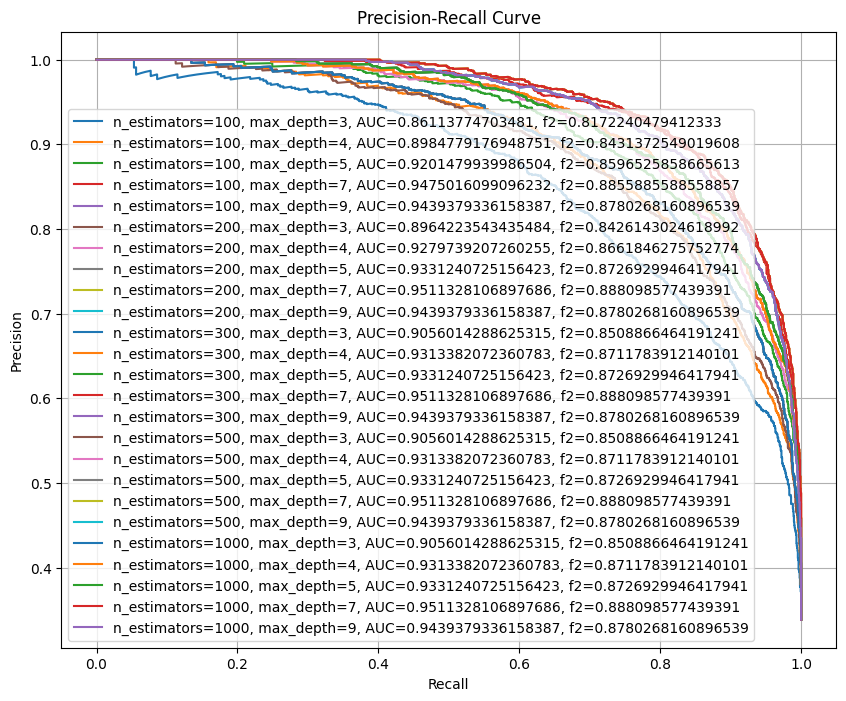

In [26]:
# we'll use this for loop before gridsearchCV to find best values of n_estimators and max_depth while minimizing overfitting risk
# this code plots the PR curves for all the values of n_estimators and max_depth below
# then, we'll take the lowest values that give the best AUC-PR
# looks like the best one is (200,7)

n_estimators_values = [100,200,300,500,1000]
max_depth_values = [3,4,5,7,9]

plt.figure(figsize=(10,8))

for n in n_estimators_values:
    for m in max_depth_values:
        xgb_clf_nm = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, n_estimators=n, max_depth=m)
        xgb_clf_nm = xgb_clf_nm.fit(
            X_train,
            y_train,
            verbose=False,
            eval_metric = f2_eval,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 20,
        )
        y_prob = xgb_clf_nm.predict_proba(X_val)[:,1]
        precision, recall, _ = precision_recall_curve(y_val, y_prob)
        auc_score = auc(recall, precision)
        
        y_pred = xgb_clf_nm.predict(X_val)
        f2 = fbeta_score(y_val, y_pred, beta=2)

        plt.plot(recall, precision, label = f'n_estimators={n}, max_depth={m}, AUC={auc_score}, f2={f2}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# gridsearchCV to help tune hyperparameters
# for our first grid search, we'll try some regularization to see if we can increase n_estimators and max_depth
# looks like we should try increasing max_depth with colsample_bytree=0.9, min_child_weight=2, and reg_lambda=10

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3)

f2_scorer = make_scorer(fbeta_score, beta=2)
param_grid = {
    'n_estimators' : [100,200,300],
    'max_depth' : [7,9],
    'min_child_weight' : [1,2,3],
    'colsample_bytree' : [0.8,0.9,1],
    'reg_lambda' : [0,1,10]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train,y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'colsample_bytree': 1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'reg_lambda': 10}
Best f2:  0.8780876188109069


c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is dep

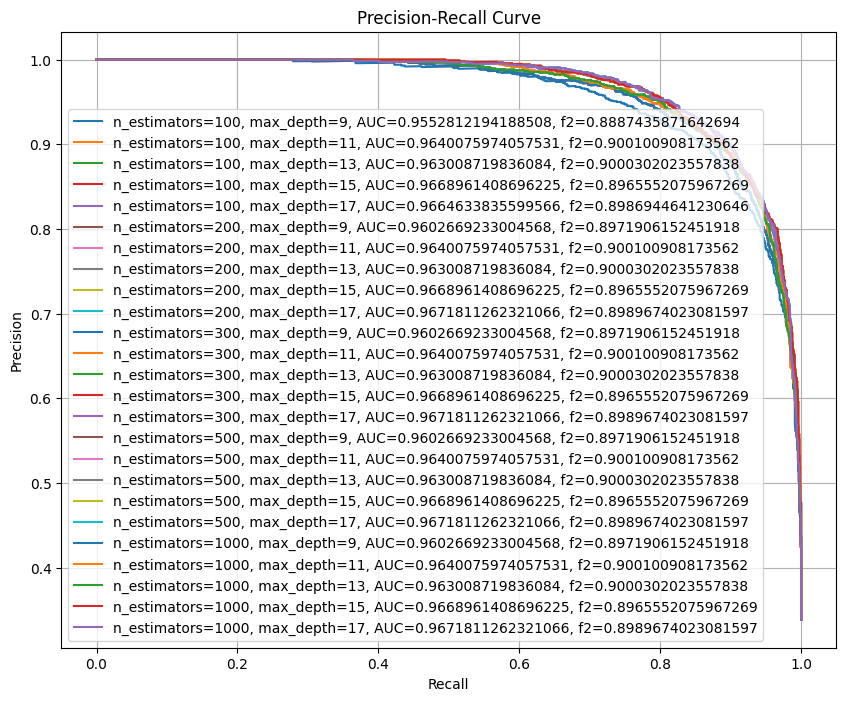

In [50]:
# now that we have some regularization, let's see how far we can increase max_depth and n_estimators
# looks like (100,13) has the best f2 and (200,17) has the best AUC-PR

n_estimators_values = [100,200,300,500,1000]
max_depth_values = [9,11,13,15,17]

plt.figure(figsize=(10,8))

for n in n_estimators_values:
    for m in max_depth_values:
        xgb_clf_nm = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, colsample_bytree=0.9, reg_lambda=10, min_child_weight=2, n_estimators=n, max_depth=m)
        xgb_clf_nm = xgb_clf_nm.fit(
            X_train,
            y_train,
            verbose=False,
            eval_metric = f2_eval,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 20,
        )
        y_prob = xgb_clf_nm.predict_proba(X_val)[:,1]
        precision, recall, _ = precision_recall_curve(y_val, y_prob)
        auc_score = auc(recall, precision)
        
        y_pred = xgb_clf_nm.predict(X_val)
        f2 = fbeta_score(y_val, y_pred, beta=2)

        plt.plot(recall, precision, label = f'n_estimators={n}, max_depth={m}, AUC={auc_score}, f2={f2}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# maybe more aggressive regularization helps increase n_estimators or max_depth further
# looks like (200,13) is the best choice, and more regularization isn't helping

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, min_child_weight=2, reg_lambda=10)

f2_scorer = make_scorer(fbeta_score, beta=2)
param_grid = {
    'n_estimators' : [100,200,300],
    'max_depth' : [13,15,17],
    'subsample' : [0.8,0.9,1],
    'colsample_bytree' : [0.8,0.9],
    'reg_alpha' : [0,0.01,0.1]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train,y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'colsample_bytree': 0.9, 'max_depth': 13, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 1}
Best f2:  0.8804556445421128


In [52]:
# finally, let's tune the learning rate
# looks like learning_rate=0.1 is best

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, n_estimators=200, max_depth=13, min_child_weight=2, colsample_bytree=0.9, reg_lambda=10)

f2_scorer = make_scorer(fbeta_score, beta=2)
param_grid = {
    'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train,y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'learning_rate': 0.1}
Best f2:  0.8809342261004854


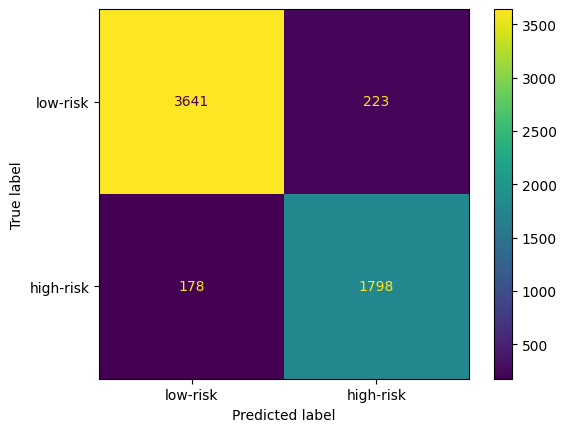

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.9313356164383562 | baseline: 0.6616438356164384
precision: 0.8896585848589807 | baseline: 0.33835616438356164
recall: 0.909919028340081 | baseline: 1
f1 score: 0.8996747560670504 | baseline: 0.5056294779938588
f2 score: 0.9057934508816121 | baseline: 0.7188591385331781
AUC-PR: 0.9667923122515636 | baseline: 0.33835616438356164


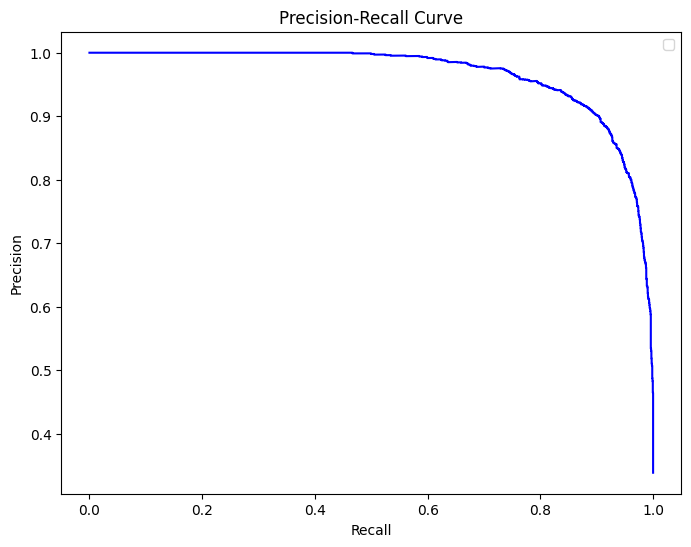

In [53]:
# evaluating all the metrics we want on the val data

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
y_prob = best_model.predict_proba(X_val)[:,1]

high_pct = y_val.sum()/len(y_val)
cm = confusion_matrix(y_val, y_pred)
precision, recall, _ = precision_recall_curve(y_val, y_prob)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low-risk", "high-risk"])
disp.plot()
plt.show()

print("accuracy: " + str(accuracy_score(y_val, y_pred)) + " | baseline: " + str(1-high_pct))
print("precision: " + str(precision_score(y_val, y_pred)) + " | baseline: " + str(high_pct))
print("recall: " + str(recall_score(y_val, y_pred)) + " | baseline: " + str(1))
print("f1 score: " + str(fbeta_score(y_val, y_pred, beta=1)) + " | baseline: " + str(2*high_pct/(high_pct+1)))
print("f2 score: " + str(fbeta_score(y_val, y_pred, beta=2)) + " | baseline: " + str(5*high_pct/(4*high_pct+1)))
print("AUC-PR: " + str(auc(recall, precision)) + " | baseline: " + str(high_pct))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

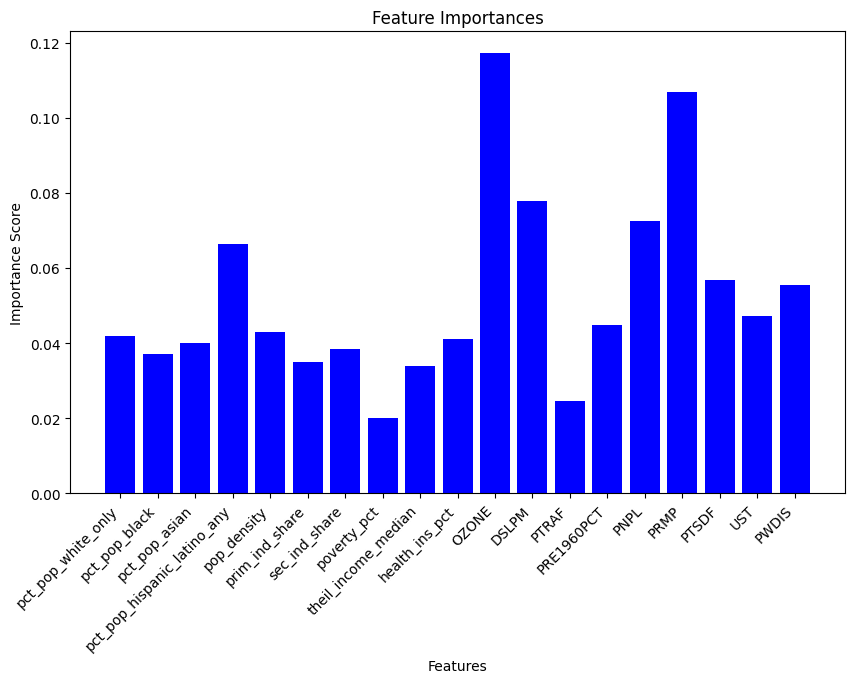

In [54]:
# compuring feature importance to see what variables our model thinks are important
# top 5 are:
# ambient ozone levels (OZONE)
# proximity to RMP facility (PRMP)
# ambient diesel PM levels (DSLPM)
# superfund proximity (PNPL)
# percent of population that is hispanic/latino (pct_pop_hispanic_latino_any)

df_features = df.drop(['PM25', 'PM25_high'], axis=1)

df_columns = df_features.columns.tolist()
feature_importance = best_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(df_columns, feature_importance, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.xticks(rotation=45, ha='right')
plt.show()